<h1><strong>Melhorando o comércio eletrônico com IA generativa</strong></h1>
<h2>Introdução</h2>

A IA generativa está revolucionando a forma como as empresas em vários domínios funcionam e o comércio eletrónico não é exceção. À medida que o comércio eletrônico cresce, o mesmo acontece com a necessidade de soluções mais escaláveis e sofisticadas. Neste notebook, exploramos várias aplicações da IA generativa no comércio eletrónico, analisando a forma como a IA generativa ajuda nas recomendações de produtos. Em primeiro lugar, os metadados de produtos foram utilizados para aprender as suas incorporações representativas e
analisado como estas incorporações ajudam a classificar os itens. Em seguida, foi calculada a incorporação do usuário com base no seu histórico de compras. Por fim, os embeddings de usuários e de itens aprendidos foram utilizados para recomendar produtos.


---

<h1><strong>1. O Conjunto de dados</strong></h1>

<h3><strong>1.1 Geração de Dados Sintéticos</strong></h3>

Embora existam muitos conjuntos de dados de itens de usuário disponíveis online, para este trabalho, geramos sinteticamente o conjunto de dados. Este conjunto de dados é composto por duas partes: 1) metadados do item e 2) dados do item do usuário. O conjunto de dados de metadados do item contém item_id, título, caraterística, descrição e categoria. Os dados de compra do item do usuário contêm user_id, item_id e timestamp. Este conjunto de dados indica que usuário comprou que item e a que horas.


In [2]:
#@title Instalando a biblioteca da API da OpenAI

!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.5 MB/s eta 0:00:00


<h3><strong>1.2 Geração de conjunto de metadados de itens</strong></h3>


Para gerar o conjunto de dados de metadados do item, foi utilizada a API openAI. Para utilizar a API é necessário ter créditos suficientes e criar uma  API key. Abaixo está o código para gerar o conjunto de dados de metadados do item.

In [3]:
from openai import OpenAI
import json
import re

client = OpenAI(api_key='insira-sua-chave')

def form_prompt():
    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "user",
            "content": """
                Gere um conjunto de dados de metadados de itens para mim que tenha cinco colunas: item_id, título, característica, descrição, categoria. Eu quero que característica e descrição sejam uma lista, e a categoria seja definida como "moda".
                A coluna item_id é um número inteiro escolhido aleatoriamente.
            """
            }
        ]
    )

    return(completion.choices[0].message.content)
if __name__ == '__main__':

    response = form_prompt()
    print(response)

Aqui está um conjunto de dados de metadados de itens com as especificações solicitadas:

| item_id | título                  | característica                     | descrição                                                  | categoria |
|---------|-------------------------|-----------------------------------|-----------------------------------------------------------|-----------|
| 101     | Camiseta Estampada      | ["algodão", "manga curta"]       | ["Camiseta de algodão leve", "Perfeita para o verão"]    | moda      |
| 102     | Calça Jeans              | ["denim", "cintura alta"]        | ["Calça jeans confortável", "Estilo clássico e casual"]   | moda      |
| 103     | Tênis Casual            | ["couro sintético", "solado flexível"] | ["Tênis ideal para o dia a dia", "Design moderno"]      | moda      |
| 104     | Vestido de Verão        | ["polyester", "estampa floral"]  | ["Vestido leve e arejado", "Ótimo para ocasiões informais"] | moda    |
| 105     | Jaqueta Bomber       

Conforme esperado, utilizando o modelo GPT-4o-mini e solicitamos que gere itens da categoria moda. Agora que o prompt está funcional, podemos alterá-lo para passar um item_id e gerar um ponto de dados:

In [ ]:
def form_prompt(item_id):

  completion = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
      {"role": "user",
      "content": """
         Eu lhe dou um item_id para um item na categoria moda, e quero que você gere título, característica e descrição para ele.
         Eu quero que a descrição seja frases completas e que características e descrição sejam uma lista.
         item id: {item_id}
            """.format(item_id=item_id)
      }
    ]
  )

  return(completion.choices[0].message.content)


In [ ]:
def parsear_resposta(resposta):
    # Regex para capturar o título
    titulo_match = re.search(r"Título:\s*(.*)", resposta)
    titulo = titulo_match.group(1).strip() if titulo_match else "Sem título"

    # Captura as características
    caracteristicas_match = re.search(r"Características:\s*([\s\S]*?)\n\n", resposta)
    caracteristicas = []
    if caracteristicas_match:
        caracteristicas_texto = caracteristicas_match.group(1).strip()
        # Dividir as características em uma lista
        caracteristicas = [linha.strip("- ").strip() for linha in caracteristicas_texto.splitlines() if linha.strip()]

    # Captura a descrição
    descricao_match = re.search(r"Descrição:\s*(.*)", resposta, re.DOTALL)
    descricao = descricao_match.group(1).strip() if descricao_match else "Sem descrição"

    return {
        "titulo": titulo,
        "caracteristicas": caracteristicas,
        "descricao": descricao
    }

def gerar_dados():
    dados = []
    for item_id in range(1, 5):
        resposta = form_prompt(item_id)
        resposta_parseada = parsear_resposta(resposta)
        item_dados = {
            "item_id": item_id,
            "titulo": resposta_parseada['titulo'],
            "caracteristicas": resposta_parseada['caracteristicas'],
            "descricao": resposta_parseada['descricao'],
            "categoria": "moda"
        }
        dados.append(item_dados)
    return dados

def save_to_json(dados, filename='item_metadata.json'):
    with open(filename, 'w') as file:
        json.dump(dados, file, indent=4)

if __name__ == '__main__':
    dados_itens = gerar_dados()
    save_to_json(dados_itens)
    print(f"Dados salvos em item_metadata.json")

Dados salvos em item_metadata.json


Para carregar a base de dados criada previamente, é necessário acessar a pasta Colab Notebooks e inserir a base de dados item_metadata.json manualmente na seção de arquivos do Colab.

<h3><strong>1.3 Geração de conjunto de dados de itens de usuário</strong></h3>


É uma tarefa mais fácil gerar sinteticamente um conjunto de dados de itens de usuário. Este conjunto de dados contém user_id, item_id e timestamp. Para o gerar, podemos fazer o seguinte:

In [ ]:
import random
from datetime import datetime, timedelta

def generate_random_timestamp(start_year=2022, end_year=2024):
    start = datetime(start_year, 1, 1)
    end = datetime(end_year, 12, 31)
    return start + (end - start) * random.random()

def create_json_file(num_records, filename):
    data = []

    for _ in range(num_records):
        item_id = random.randint(1, 500)
        user_id = random.randint(1, 100)
        timestamp = generate_random_timestamp().strftime('%Y-%m-%d %H:%M:%S')

        record = {
            "item_id": item_id,
            "user_id": user_id,
            "timestamp": timestamp
        }

        data.append(record)

    with open(filename, 'w') as file:
        json.dump(data, file, indent=4)

No código acima, assumimos que existem 500 itens e 100 usuários. Podemos gerar o ficheiro item_user_data.json da seguinte forma:

In [ ]:
create_json_file(3500, 'item_user_data.json')



---



<h1><strong>2. Aprendizagem de Embeddings Representativos para Itens</strong></h1>

Para recomendar produtos aos usuários, é necessário, em primeiro lugar, aprender uma representação dos itens/produtos. Depois disso, utilizamos o histórico de compras dos usuários para obter uma representação dos mesmos com base nos artigos que compraram. Só então, quando tivermos representações dos usuários e dos produtos, poderemos fazer a recomendação dos produtos.

Assim, primeiro calculamos um embeddings representativo para os itens com base na sua caraterística, título e descrição. O objetivo aqui é ter uma incorporação que reflicta a categoria ou subcategoria do item. Se encontrarmos uma tal incorporação, podemos utilizá-la para identificar a categoria (ou subcategoria) de novos itens.

<h3><strong>2.1 Preparação e limpeza de dados</strong></h3>

Começamos por carregar os dados. Lemos o conjunto de dados item-metadata, que contém metadados sobre produtos da categoria moda:

In [ ]:
import pandas as pd
meta_df = pd.read_json("item_metadata.json")

Para garantir que trabalhamos com pontos de dados de alta qualidade, devemos filtrar as linhas que têm uma lista vazia para a caraterística e a descrição. Também devemos filtrar as linhas que têm menos de 10 características, porque quanto mais características um produto tiver, melhor será a incorporação que podemos calcular para ele. O objetivo do processo de limpeza é manter apenas as linhas de alta qualidade.

In [ ]:
# Aplicar máscaras para filtrar linhas onde 'caracteristicas' e 'descricao' não são listas vazias
mask1 = meta_df['caracteristicas'].apply(lambda x: x != [])
mask2 = meta_df['descricao'].apply(lambda x: x != [])

# Filtrar DataFrame com base nas máscaras
df2 = meta_df[mask1 & mask2].copy()  # Usar .copy() para evitar o SettingWithCopyWarning

# Adicionar a coluna 'Tamanho' que conta o número de características
df2['Tamanho'] = df2['caracteristicas'].apply(len)

# Filtrar para manter apenas as linhas onde 'Tamanho' é maior ou igual a 10
df3 = df2[df2['Tamanho'] >= 5]

# Mostrar o shape do DataFrame final
print(df3.shape)

(500, 6)


<h3><strong>2.2 Combinando recursos, descrição e título</strong></h3>

Em seguida, combinamos três colunas de características, descrição e título numa coluna e utilizamo-la para calcular os vectores de incorporação dos produtos:


In [ ]:
# Criar uma cópia segura do DataFrame
df3_copy = df3.copy()

# Adicionar a coluna 'j_features' usando .loc[]
df3_copy.loc[:, 'j_features'] = df3_copy['caracteristicas'].apply(lambda x: ', '.join(x))

# Adicionar a coluna 'j_description' usando .loc[]
df3_copy.loc[:, 'j_description'] = df3_copy['descricao']

# Criar a coluna 'combined' usando .loc[]
df3_copy.loc[:, 'combined'] = df3_copy.apply(lambda row: f"{row['titulo']} {row['j_features']} {row['j_description']}", axis=1)



<h3><strong>2.3 Usando <I>sentence-transformers</I> para <I>Embbeding</I></strong></h3>

Podemos utilizar qualquer LLM pré-treinado para calcular a incorporação de itens, mas neste trabalho foi utilizado transformadores de frases, uma vez que a descrição contém frases e os transformadores de frases são conhecidos por aprenderem melhores representações para frases.

In [ ]:
#@title Instalando o transformador de frases
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 4.3 MB/s eta 0:00:00


In [ ]:
#@title Carregando um dos modelos
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
#@title Cálculo do Embedding

# Calcular as incorporações e adicioná-las à coluna 'embeddings'
df3_copy['embeddings'] = df3_copy['combined'].apply(lambda x: model.encode(x))


<h3><strong>2.4 Avaliação de <I>Embeddings</I> de itens</strong></h3>

Agora, vamos verificar a qualidade das incorporações. É realmente representativa da categoria ou subcategoria do item? Optamos por verificar a subcategoria, uma vez que todos os itens que carregamos e inferimos embeddings estão numa categoria, ou seja, moda.

<h3><strong>2.5 Atribuição de subcategoria</strong></h3>

Assim, primeiro vamos adicionar uma coluna sub_categoria ao nosso conjunto de dados:

In [ ]:
def atribuir_sub_categoria(x):
    x = x.lower()
    for sub_cat in ['roupa', 'joia', 'sapato', 'relogio']:
        if sub_cat in x:
            return sub_cat
    for sub_cat in ['bolsa', 'carteira']:
        if sub_cat in x:
            return 'bolsa & carteira'
    for sub_cat in ['cinto', 'chapeu', 'cachecol', 'oculos de sol', 'gravata']:
        if sub_cat in x:
            return sub_cat
    for sub_cat in ['roupa esportiva', 'roupa de banho', 'roupa de inverno', 'meias']:
        if sub_cat in x:
            return sub_cat
    for sub_cat in ['bagagem', 'mochila', 'viagem']:
        if sub_cat in x:
            return 'bagagem & acessórios de viagem'
    for sub_cat in ['roupa intima', 'roupa de baixo']:
        if sub_cat in x:
            return 'roupa intima'
    return 'outros'

  # Adicionar a coluna 'sub_categoria' usando .loc[]
df3_copy.loc[:, 'sub_categoria'] = df3_copy['combined'].apply(lambda x: atribuir_sub_categoria(x))

# Verificar os resultados
print(df3_copy[['combined', 'sub_categoria']].head())


                                            combined sub_categoria
0  ** Vestido Midi Floral com Alças Finas **, Mat...        outros
1  ** Vestido Longo Floral com Alças Finas **, Ma...         roupa
2  Tênis Casual Estiloso para o Dia a Dia Materia...         roupa
3  Vestido Floral Midi com Decote em V **Estampa:...         roupa
4  Saia de Couro com Cinto Material: 100% couro, ...         roupa




```
{0: 'cinto',
1: 'roupas',
2: 'bolsa e carteira',
3: 'chapéu',
4: 'outros',
5: 'cachecol',
6: 'sapato',
7: 'meias',
8: 'gravata',
9: 'relógio'}
```



<h3><strong>2.6 Visualização <I>TSNE</I></strong></h3>

Agora, que cada item tem uma incorporação e uma subcategoria, vamos desenhá-las em 2D através da TSNE e ver se existem agrupamentos óbvios:

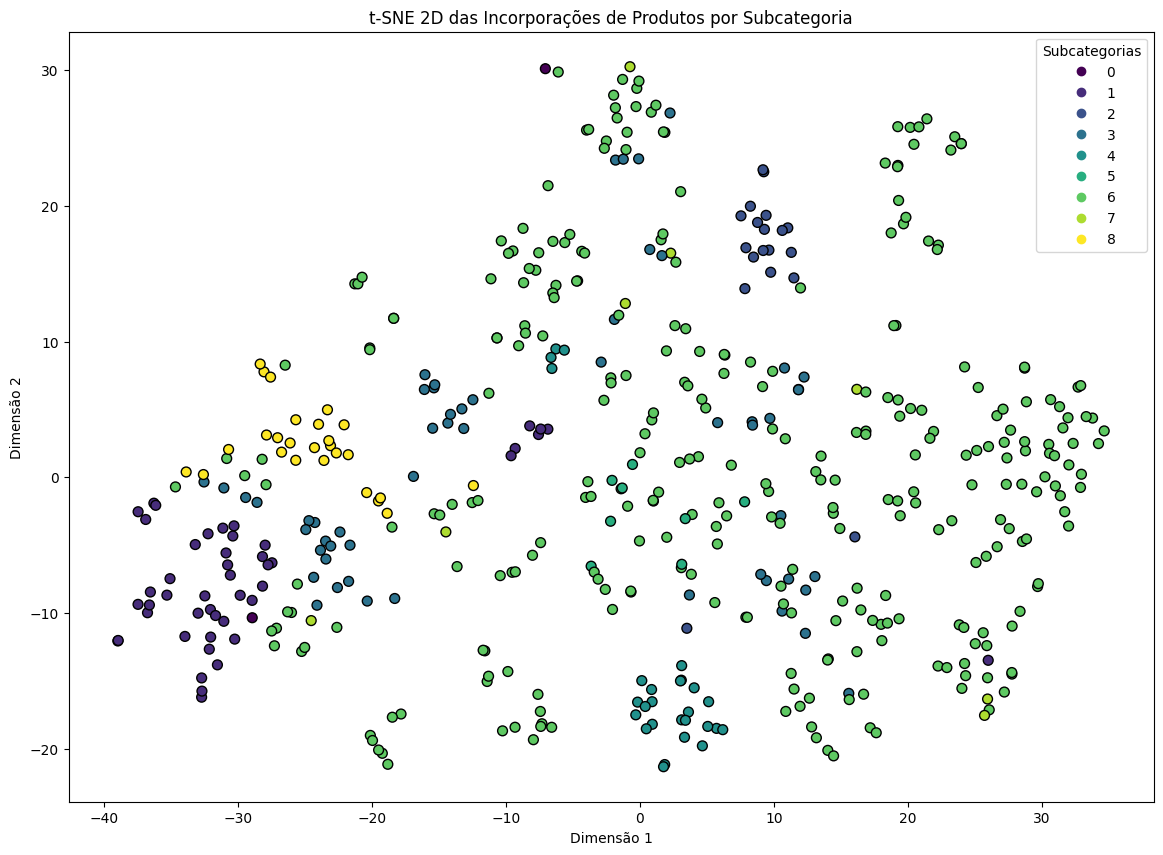

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Certifique-se de que a coluna 'embeddings' foi criada e contém os dados corretos
embeddings_array = np.array(df3_copy['embeddings'].tolist())

# Garantir que a coluna 'sub_categoria' existe e contém valores válidos
categories = df3_copy['sub_categoria'].astype('category').cat.codes

# Verificar o número de amostras e ajustar perplexity
n_samples = len(embeddings_array)
perplexity_value = max(5, min(30, n_samples - 1))  # Certifica-se de que perplexity está entre 5 e (n_samples - 1)

# Aplicar t-SNE para reduzir as incorporações para 2D
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_array)

plt.figure(figsize=(14, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=categories, cmap='viridis', edgecolor='k', s=50)

# Adicionar a legenda de acordo com as subcategorias
plt.legend(*scatter.legend_elements(), title="Subcategorias")
plt.title('t-SNE 2D das Incorporações de Produtos por Subcategoria')
plt.xlabel('Dimensão 1')
plt.ylabel('Dimensão 2')
plt.show()


Se prestar muita atenção ao gráfico, pode ver alguns grupos de itens. Por exemplo, os pontos amarelos formam um grupo que corresponde ao número 8, que corresponde a gravatas. Outro grupo é o verde escuro representando os chapéus (número 3), no meio do gráfico, mais abaixo, e outro grupo mais espalhado é o número 6 que corresponde aos sapatos.

Apesar de estarmos em 2D e de, devido à redução da dimensão, termos perdido muita informação, os embeddings continuam a representar as subcategorias.

<h3><strong>2.7 Classificação <I>KNN</I></strong></h3>

De seguida, vamos utilizar estes embeddings para classificar os itens na sua subcategoria. Para o fazer, utilizamos o algoritmo de classificação KNN (K Nearest Neighbor) do Scikit-learn:



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

X = np.array(df3_copy['embeddings'].tolist())
y = df3_copy['sub_categoria']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Initialize and train the k-NN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

bolsa & carteira       0.87      0.93      0.90        14
        cachecol       1.00      0.80      0.89        10
           cinto       0.88      0.61      0.72        23
         gravata       1.00      1.00      1.00         4
           meias       0.00      0.00      0.00         3
          outros       0.85      0.97      0.91        89
          sapato       0.83      0.71      0.77         7

        accuracy                           0.87       150
       macro avg       0.78      0.72      0.74       150
    weighted avg       0.85      0.87      0.85       150



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Vemos que a média ponderada da precisão, da recuperação e da pontuação f1 se situa na ordem dos 85%, o que é bom. É mais um sinal de que os embeddings são representativos do campo da subcategoria.



---



<h1><strong>3. Representação de aprendizagem para usuários</strong></h1>

Para construir embeddings de usuários, carregamos o arquivo *item_user_data.json*. Este conjunto de dados contém os itens que os usuários compraram:

In [ ]:
import pandas as pd
purchase_df = pd.read_json("item_user_data.json")
print(purchase_df)

      item_id  user_id           timestamp
0         345       87 2023-04-22 05:44:52
1         224       19 2022-12-10 08:57:15
2         257       50 2023-04-24 20:20:35
3         250       31 2023-11-24 21:14:42
4         467       61 2022-02-27 11:55:04
...       ...      ...                 ...
3495       10       55 2022-02-10 12:16:14
3496      219       97 2023-10-23 05:40:58
3497      128       72 2023-03-27 05:15:37
3498      406       43 2022-08-12 12:12:31
3499      427        1 2022-10-03 08:18:20

[3500 rows x 3 columns]


<h3><strong>3.1 Seleção de usuários de alta qualidade</strong></h3>

O que queremos fazer é **selecionar usuários de alta qualidade**, esses são usuários que têm um longo histórico de compras. Então, classificamos suas compras no tempo e escolhemos as primeiras N compras como dados de treinamento e as restantes como dados de teste. Os dados de treinamento nos ajudarão a construir sua representação (ou incorporação), e os dados de teste nos permitem testar a qualidade de sua incorporação.

Primeiramente, iremos converter a coluna *timestamp* para *unix epoch time* em termos de segundos:

In [ ]:
# Convertendo 'timestamp' para 'unix epoch time' em segundos
purchase_df.loc[:, 'timestamp_int'] = purchase_df['timestamp'].astype(int) // 10**9
print(purchase_df)

      item_id  user_id           timestamp  timestamp_int
0         345       87 2023-04-22 05:44:52     1682142292
1         224       19 2022-12-10 08:57:15     1670662635
2         257       50 2023-04-24 20:20:35     1682367635
3         250       31 2023-11-24 21:14:42     1700860482
4         467       61 2022-02-27 11:55:04     1645962904
...       ...      ...                 ...            ...
3495       10       55 2022-02-10 12:16:14     1644495374
3496      219       97 2023-10-23 05:40:58     1698039658
3497      128       72 2023-03-27 05:15:37     1679894137
3498      406       43 2022-08-12 12:12:31     1660306351
3499      427        1 2022-10-03 08:18:20     1664785100

[3500 rows x 4 columns]


Por conseguinte, uma nova coluna *timestamp_int* é adicionada e, em seguida, selecionamos então usuários que são de “alta qualidade”, ou seja, que têm um longo histórico de compras. Aqui definimos “longo” como 30 itens ou mais:

In [ ]:
users_to_items = {}

for _,row in purchase_df.iterrows():
    user = row['user_id']
    item = row['item_id']
    time = row['timestamp_int']
    if user not in users_to_items:
        users_to_items[user] = []
    users_to_items[user].append((item, time))


selected_users = {}
for k,v in users_to_items.items():
    items = list(set([x[0] for x in v]))
    if len(items)>=30:
        selected_users[k] = v

# Isso faz com que o 'selected_users' é o nosso dicionário para trabalhar.

<h3><strong>3.2 Divisão de teste de treinamento para dados do usuário</strong></h3>

Com os dados desses usuários, vamos dividi-los em treinamento e testes:


In [ ]:
from collections import defaultdict

def split_user_data(selected_users, test_size=10):
    train_data = defaultdict(list)
    test_data = defaultdict(list)

    for user, purchases in selected_users.items():
        # Classificar compras por tempo
        sorted_purchases = sorted(purchases, key=lambda x: x[1])

        # Dividir em treinamento e teste
        if len(sorted_purchases) > test_size:
            train_data[user] = sorted_purchases[:-test_size]
            test_data[user] = sorted_purchases[-test_size:]
        else:
            train_data[user] = []
            test_data[user] = sorted_purchases

    return dict(train_data), dict(test_data)

train_data, test_data = split_user_data(selected_users, test_size=10)

Dado a isso, pegamos as últimas 10 compras de cada usuário como seus dados de teste, e o restante como seus dados de treinamento. Visto que esses 10 itens são seus exemplos positivos, signifca que, esses são os itens que os usuários realmente compraram.



<h3><strong>3.3 Adicionando Exemplos Negativos</strong></h3>

Paralemente, é necessário incluir alguns exemplos negativos, ou seja, itens que os usuários não compraram. Para isso, selecionamos aleatoriamente 10 itens de todos os itens disponíveis, que não estão no histórico de compras do usuário nem nos dados de teste que queremos prever. Esses itens formam nossos exemplos negativos.

In [ ]:
import random

# Coletar todos os itens exclusivos
all_items = set()
for purchases in selected_users.values():
    for item, _ in purchases:
        all_items.add(item)

# Mostrar 10 itens para cada usuário que eles não compraram
negative_examples = {}
for user, purchases in selected_users.items():
    user_items = {item for item, _ in purchases}
    available_items = list(all_items - user_items)
    if len(available_items) >= 10:
        sampled_items = random.sample(available_items, 10)
    else:
        sampled_items = available_items  # Se menos de 10, retornar todos os disponíveis
    negative_examples[user] = sampled_items

Nossos exemplos positivos também são o conjunto de itens que os usuários compraram. Este conjunto também contém 10 exemplos positivos por usuário.

In [ ]:
# Exemplos positivos
positive_examples = {}
for k,v in test_data.items():
    positive_examples[k] = [item[0] for item in v]

Assim, podemos afirmar que o conjunto de teste é a união tanto de exemplos positivos quanto exemplos negativos para cada usuário:

In [ ]:
test_set = {}
for user, v in positive_examples.items():
    test_set[user] = list(set(v + negative_examples[user]))



---



<h1><strong>4. Avaliando a qualidade das recomendações</strong></h1>

<h3><strong>4.1 Métrica <I>Precision@k</I> e sua implementação</strong></h3>

Para avaliar a qualidade das recomendações, usamos uma métrica comum. Essa métrica é <i>precision@k</i>, na qual ela analisa os principais <i>k</i> itens recomendados e mede qual porcentagem de relevância deles, onde a relevância significaria que eles estão em exemplos positivos do usuário.

A definição de <i>precision@k</i> é a seguinte: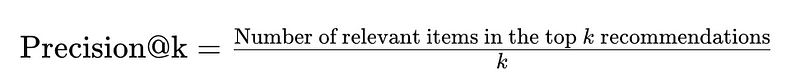

In [ ]:
def precision_at_k(user_recommendations, k): # É um dicionário onde as keys são user_id e os valores são listas de tuplas com (item, relevância) -> A relevância indica se o item é relevante (1) ou não (0)
    """
    Calcule a precisão em k para um conjunto de recomendações do usuário.

    :param user_recommendations: dict, onde key é um ID de usuário e value é uma lista de tuplas (item, relevância)
    :param k: int, o número de recomendações principais a serem consideradas
    :return: média de precisão em k pontuações para todos os usuários
    """
    precision_scores = {} # É um dicionário que armazenará a precisão de cada usuário

    for user, recommendations in user_recommendations.items():
        # Pega as principais recomendações k para o usuário
        top_k_recommendations = recommendations[:k]

        # Conta o número de itens relevantes nas principais recomendações k
        relevant_count = sum([1 for item, relevance in top_k_recommendations if relevance == 1])

        # Calcula a precisão em k
        precision = relevant_count / k

        precision_scores[user] = precision

    l = list(precision_scores.values())
    return 100 * sum(l) / len(l)

    # Multiplicamos por 100 para expressão a precisão em porcentagem



---



<h1><strong>5. Construindo Embeddings de Usuários</strong></h1>

Tendo a métrica de avaliação e os dados também prontos, podemos construir embeddings de usuários.

<h3><strong>5.1 Abordagem 1: Usuários como uma sacola de suas compras</strong></h3>

O método mais simples é definir o embedding do usuário como um saco de embeddings de seus itens. Nessa abordagem, não há um embedding atribuído a um usuário, mas uma lista de embeddings é considerada como um representante para o usuário.

Vamos carregar os embeddings e calcular as pontuações de similaridade de cosseno entre o *test_set* (que contém exemplos positivos e negativos) e o embedding do usuário.

In [ ]:
import json
import numpy as np
from numpy.linalg import norm
from collections import defaultdict
import ast

# Simulação de carregamento de dados de um arquivo
item_user_data = {
    "item1": np.random.rand(10).tolist(),
    "item2": np.random.rand(10).tolist(),
    "item3": np.random.rand(10).tolist(),
}

# Converte os dados em formato apropriado e salva em JSON
with open('fashion_item_emb.json', 'w') as f:
    json.dump(item_user_data, f)

def compute_scores(train_data, test_set, embeddings_file):
    # Carregar embeddings
    with open(embeddings_file, 'r') as f:
        embeddings = json.load(f)

    # Inicializar o dicionário de resultados
    scores = defaultdict(list)

    # Calcular pontuações para cada usuário
    for user, train_items in train_data.items():
        train_items = [item for item, _ in train_items]
        train_vectors = [embeddings[item] for item in train_items if item in embeddings]

        if user in test_set:
            test_items = test_set[user]
            for test_item in test_items:
                if test_item in embeddings:
                    test_vector = embeddings[test_item]
                    similarity_sum = sum(cosine_similarity(test_vector, train_vector) for train_vector in train_vectors)
                    scores[user].append((test_item, similarity_sum))

    return dict(scores)

embeddings_file = 'fashion_item_emb.json'  # Este arquivo contém os embeddings
scores = compute_scores(train_data, test_set, embeddings_file)

Agora que temos as recomendações de cada usuário, vamos ordenar as formas decrescentes e adicionar relevância (1 ou 0):

In [ ]:
users_recom = {}
for user, v in scores.items():
    users_recom[user] = []
    ll = sorted(v, key=lambda x: x[1], reverse=True)
    for item,_ in ll:
        if item in positive_examples[user]:
            users_recom[user].append((item, 1))
        else:
            users_recom[user].append((item, 0))

Vamos imprimir *precision@k* para k=1, 3, 5.

In [ ]:
def precision_at_k(sorted_scores, k):
    relevant_items = {item for item, relevance in sorted_scores if relevance[1] == 1}
    retrieved_items = {item for item, _ in sorted_scores[:k]}

    if len(retrieved_items) == 0:  # Para evitar divisão por zero
        return 0.0

    # Calculating Precision
    true_positives = len(relevant_items.intersection(retrieved_items))
    return true_positives / len(retrieved_items)

k_values = [2, 5]
for k in k_values:
    precision = precision_at_k(sorted_scores, k)
    print(f'Precision@{k}: {precision *100 :.2f}' )

Precision@2: 50.00
Precision@5: 66.67


<h3><strong>5.2 Abordagem 2: Média ponderada em decaimento exponencial
</strong></h3>

Nessa abordagem, calculamos a média ponderada exponencialmente decrescente de embeddings de itens. Em termos simples, um embedding de usuário é a média ponderada de seus embeddings de itens, onde o peso é definido pela função exponencial.

In [ ]:
import numpy as np

def compute_user_embedding(purchases, item_embeddings, decay_rate=0.001):
    """
    Calcule o embedding do usuário como a média ponderada de embeddings de itens.
    """

    if not purchases:
        return np.zeros_like(next(iter(item_embeddings.values())))

    # Extrair item_ids e timestamps
    item_ids, timestamps = zip(*purchases)
    valid_item_ids, valid_timestamps = [],[]

    for i, item_id in enumerate(item_ids):
        if item_id in item_embeddings:
            valid_item_ids.append(item_id)
            valid_timestamps.append(timestamps[i])

    # Normalizar timestamps
    normalized_timestamps = max(valid_timestamps) - np.array(valid_timestamps)

    # Calcular pesos usando decaimento exponencial
    weights = np.exp(-decay_rate * normalized_timestamps)

    # Calcular embeddings ponderados
    embeddings = np.array([item_embeddings[item_id] for item_id in valid_item_ids])
    weighted_embeddings = embeddings * weights[:, np.newaxis]

    # Calcular a média ponderada
    user_embedding = weighted_embeddings.sum(axis=0) / weights.sum()

    return user_embedding

Na função acima, os parâmetros são os seguintes: — *purchases* : Lista de tuplas (item_id, timestamp) — *item_embeddings* : Dicionário mapeando item_id para vetor de incorporação — *decay_rate* : Taxa de decaimento exponencial para ponderar a atualidade.

Agora que temos os embeddings dos usuários, vamos calcular recomendações e medir *precision@k*.

In [ ]:
def compute_recoms_exp_decay(user_embedding, test_set, embeddings_file, positive_examples):
    #Carregar os embeddings
    embeddings = load_embeddings(embeddings_file)
    scores = defaultdict(list)
    users_recom = defaultdict(list)

    # Calcular scores
    for user, user_emb in user_embedding.items():
        if user in test_set:
            test_items = test_set[user]
            for test_item in test_items:
                if test_item in embeddings:
                    test_vector = embeddings[test_item]
                    similarity_score = cosine_similarity(test_vector, user_emb)
                    scores[user].append((test_item, similarity_score))

        ll = sorted(scores[user], key=lambda x: x[1], reverse=True)
        for item,_ in ll:
            if item in positive_examples[user]:
                users_recom[user].append((item, 1))
            else:
                users_recom[user].append((item, 0))
    return users_recom

In [ ]:
def precision_at_k(relevant_items, retrieved_items, k):
    """
    Calcula a precisão@k.

    :param relevant_items: Conjunto de itens relevantes (list)
    :param retrieved_items: Resultados retornados pelo sistema (list)
    :param k: Número de itens a considerar (int)
    :return: Precisão@k (float)
    """
    # Limitar k ao tamanho da lista de itens recuperados
    k = min(k, len(retrieved_items))

    # Contar o número de itens relevantes nos k primeiros resultados
    relevant_count = sum(1 for item in retrieved_items[:k] if item in relevant_items)

    # Calcular precisão@k
    precision = relevant_count / k
    return precision

# Exemplo de uso
if __name__ == "__main__":
    relevant = ['item1', 'item2', 'item3', 'item4']
    retrieved = ['item1', 'item5', 'item3', 'item6', 'item7']
    k = 3

    precision = precision_at_k(relevant, retrieved, k)
    print(f'Precision@{k}: {precision *100 :.2f}')

Precision@3: 66.67




---



<h1><strong>Conclusão</strong></h1>

Analisamos o problema da recomendação no domínio do e-commerce e exploramos como a IA generativa pode ajudar a calcular recomendações relevantes para os usuários.

Primeiro, mostramos como gerar os dados sinteticamente e, em seguida, dividimos o problema em dois subproblemas: 1) aprendizado de embeddings de itens e 2) aprendizado de embeddings de usuários e, finalmente, o uso dos dois embeddings para calcular uma pontuação de similaridade como uma pontuação de recomendação. Também falamos sobre uma métrica de avaliação comum chamada *precision@k*, que mede a qualidade dos principais k itens recomendados.

Recomendação é um dos muitos aspectos que a IA generativa pode melhorar significativamente no domínio do e-commerce.



---



<h1><strong>Referências</strong></h1>

[<link> https:/towardsdatascience.com/enhancing-e-commerce-with-generative-ai-part-1-9e402fb30e7b </link>](https://)

<h1><strong>Integrantes</strong></h1>
<h3>Giulia de Oliveira Machado RA: 11202130151<br>
Isabelly Oliveira RA: 11202231155<br>
Wagner Ryu Kamiya RA: 11202231732</h3>